# Openpilot White-Box Adversarial Attack 

## Install libraries

In [ ]:
# Install pip packages
%pip install -r requirements.txt

## Import libraries

In [28]:
import sys
import os
import re
import json

import onnx
import onnxruntime
from onnx2torch import convert
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt

## Set up the environment

In [61]:
# Load Supercombo ONNX model
model_name = "supercombo_0.8.3.onnx" # For 0.9.4: supercombo_0.9.4.onnx
onnx_model = onnx.load(model_name)

# Conver to PyTorch model
torch_model = convert(onnx_model)
if torch.cuda.is_available():
    torch_model.cuda()
#torch_model.half() # Make the model use float16 dtype
torch_model.eval()
#print(torch_model)

# Session ONNX
session = onnxruntime.InferenceSession(model_name, providers=['CPUExecutionProvider'])

## Image treatment: processing, conversion, display, etc.

In [62]:
def rgb_to_yuv(rgb_tensor):
    # Ensure tensor is in (N, C, H, W) format
    assert rgb_tensor.dim() == 4 and rgb_tensor.size(1) == 3, "Input tensor must be in (N, C, H, W) format with 3 channels"

    # Convert RGB to YUV
    R = rgb_tensor[:, 0, :, :]
    G = rgb_tensor[:, 1, :, :]
    B = rgb_tensor[:, 2, :, :]

    Y = 0.299 * R + 0.587 * G + 0.114 * B
    U = -0.14713 * R - 0.28886 * G + 0.436 * B
    V = 0.614 * R - 0.51498 * G - 0.10001 * B

    yuv_tensor = torch.stack([Y, U, V], dim=1)
    return yuv_tensor

def parse_image(frame):
    # Ensure frame is a tensor of shape (1, 3, H, W)
    assert frame.dim() == 4 and frame.size(1) == 3, "Input tensor must be of shape (1, 3, H, W)"
    
    H = frame.size(2)
    W = frame.size(3)
    
    # Initialize the parsed tensor with shape (6, H//2, W//2)
    parsed = torch.zeros((6, H//2, W//2), dtype=torch.uint8)
    
    # Extract the channels from the input tensor
    Y = frame[0, 0, :, :]
    U = frame[0, 1, :, :]
    V = frame[0, 2, :, :]

    # Populate the parsed tensor
    parsed[0] = Y[0:H:2, 0::2]
    parsed[1] = Y[1:H:2, 0::2]
    parsed[2] = Y[0:H:2, 1::2]
    parsed[3] = Y[1:H:2, 1::2]
    parsed[4] = U[0:H//2, 0::2]
    parsed[5] = V[0:H//2, 0::2]
    
    return parsed.unsqueeze(0)

def preprocess_frame(frame_tensor, roi_area=None, resize_dim=(128,256)):
    x, y, w, h = roi_area
    # Extract ROI (Region Of Interest) area of an image
    roi_tensor = frame_tensor[:, :, y:y+h, x:x+w]
    # Resize the images to the required dimensions
    roi_tensor_resized = F.interpolate(roi_tensor, size=resize_dim, mode='bilinear', align_corners=False)
    # Convert to YUV
    roi_tensor_resized_yuv = rgb_to_yuv(roi_tensor_resized)
    # Parse YUV with 6 channels: YUV_4:2:0
    parsed_frame = parse_image(roi_tensor_resized_yuv)
    return parsed_frame

def display_image(image):
	plt.imshow(image)
	plt.show()
	plt.clf()

def display_img(image):
	plt.imshow(image)
	plt.axis('off')
	plt.show()
	plt.clf()

def subplot(img1, img2):
	# Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the frame in the first subplot
    ax1.imshow(img1)
    ax1.set_title('Original Frame')
    ax1.axis('off')

    # Display the adversarial patch in the second subplot
    ax2.imshow(img2)
    ax2.set_title('Adversarial Patch')
    ax2.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

## Numpy and Tensors data types conversions

In [64]:
def numpy_to_tensor(array):
	# Convert image from BGR to RGB as PyTorch uses RGB by default
	frame_rgb = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
	# Convert to float32 for precision, then to float16
	tensor = torch.tensor(frame_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
	return tensor.to(torch.float16)

def tensor_to_numpy(tensor):
	# Convert back to float32 to avoid overflow when converting to uint8
	tensor_float32 = tensor.squeeze(0).permute(1, 2, 0).to(torch.float32)
	image_back = tensor_float32.detach().numpy().astype(np.uint8)
	# Convert RGB back to BGR
	return cv2.cvtColor(image_back, cv2.COLOR_RGB2BGR)

def check_images_conversion(frame):
	# Step 1: Load the image using OpenCV
	#frame = cv2.imread(data_dir + frame_name)

	# Step 2: Convert the image to a PyTorch tensor in float16
	# Convert image from BGR to RGB as PyTorch uses RGB by default
	frame_rgb = numpy_to_tensor(frame)

	# Step 3: Convert the tensor back to a NumPy array
	# Convert back to float32 to avoid overflow when converting to uint8
	image_back_bgr = tensor_to_numpy(frame_rgb)

	# Check if both images are the same
	assert np.array_equal(frame, image_back_bgr), "The images are not the same!"
	display_img(frame)
	display_img(image_back_bgr)

## Input and Output processing

In [65]:
def convert_to_meters(normalized_y_position, scaling_factor=10):
    """
    Converts the normalized Y position to real-world distance in meters.
    
    Parameters:
    normalized_y_position: The Y position from the Supercombo output (normalized distance).
    scaling_factor: A conversion factor to map the normalized Y position to meters (empirical or from camera calibration).
    
    Returns:
    distance_meters: The longitudinal distance in meters.
    """
    # Apply a scaling factor to convert normalized distance to meters
    distance_meters = torch.abs(normalized_y_position) * scaling_factor  # Use abs() to ensure positive distance
    return distance_meters

def extract_lead_predictions(output, lead_idx_start=5755, lead_idx_end=5860, distance_lead=0, distance_ego=0):
    if model_name == 'supercombo_0.8.3.onnx': # 58 floats: 5*[4*2+3]+3 https://github.com/commaai/openpilot/blob/3766830f6588df6a1fee3e0295c689f9de364476/selfdrive/modeld/models/driving.cc
        # ------------------------------------------------------------------------
        DESIRE_PRED_SIZE = 32
        OTHER_META_SIZE = 4
        MODEL_WIDTH = 512
        MODEL_HEIGHT = 256
        MODEL_FRAME_SIZE = MODEL_WIDTH * MODEL_HEIGHT * 3 // 2
        PLAN_MHP_N = 5
        PLAN_MHP_COLUMNS = 30
        PLAN_MHP_VALS = 30 * 33
        PLAN_MHP_SELECTION = 1
        PLAN_MHP_GROUP_SIZE = 2 * PLAN_MHP_VALS + PLAN_MHP_SELECTION
        LEAD_MHP_N = 5
        LEAD_MHP_VALS = 4
        LEAD_MHP_SELECTION = 3
        LEAD_MHP_GROUP_SIZE = 2 * LEAD_MHP_VALS + LEAD_MHP_SELECTION
        POSE_SIZE = 12
        # Index calculations
        PLAN_IDX = 0
        LL_IDX = PLAN_IDX + PLAN_MHP_N * PLAN_MHP_GROUP_SIZE
        LL_PROB_IDX = LL_IDX + 4 * 2 * 2 * 33
        RE_IDX = LL_PROB_IDX + 4
        LEAD_IDX = RE_IDX + 2 * 2 * 2 * 33
        LEAD_PROB_IDX = LEAD_IDX + LEAD_MHP_N * LEAD_MHP_GROUP_SIZE
        DESIRE_STATE_IDX = LEAD_PROB_IDX + 3
        DESIRE_LEN = 8  # Replace with the actual value of DESIRE_LEN
        META_IDX = DESIRE_STATE_IDX + DESIRE_LEN
        POSE_IDX = META_IDX + OTHER_META_SIZE + DESIRE_PRED_SIZE
        OUTPUT_SIZE = POSE_IDX + POSE_SIZE
        # ------------------------------------------------------------------------
        # Lead distance
        RADAR_TO_CAMERA = 1.52  # RADAR is ~ 1.5m ahead from center of mesh frame
        lead_data = output[LEAD_IDX:LEAD_PROB_IDX]
        lead_mhp_groups = [lead_data[i*LEAD_MHP_GROUP_SIZE:(i+1)*LEAD_MHP_GROUP_SIZE] for i in range(0, LEAD_MHP_N)]
        lead_dists = [lead[3] for lead in lead_mhp_groups] # x values
        v_lead = lead_dists[0]
        # https://github.com/commaai/openpilot/blob/e442425c9d32774e50802cd5455313090060f4ad/selfdrive/controls/radard.py#L62
        # https://github.com/commaai/openpilot/blob/3766830f6588df6a1fee3e0295c689f9de364476/selfdrive/controls/lib/longitudinal_planner.py
        #DT_MDL = 0.05 # https://github.com/commaai/openpilot/blob/e442425c9d32774e50802cd5455313090060f4ad/common/realtime.py#L14
        #distance_ego = distance_ego + speed_ego * DT_MDL
        #distance_lead = distance_lead + v_lead * DT_MDL # https://github.com/commaai/openpilot/blob/e442425c9d32774e50802cd5455313090060f4ad/selfdrive/test/longitudinal_maneuvers/plant.py#L17
        #lead_dist = lead_mhp_groups[0][0]
        # ¿Como sacar la distancia?
        lead_dist = convert_to_meters(lead_mhp_groups[0][1])
        # Lead confidence
        lead_probs = torch.sigmoid(output[LEAD_PROB_IDX:LEAD_PROB_IDX+3])
        best_prob_idx = torch.argmax(lead_probs)
        lead_prob = lead_probs[best_prob_idx]
        #sys.exit(0)
    elif model_name == 'supercombo_0.9.4.onnx': # 105 floats: [4*6*2+3]+3 https://github.com/commaai/openpilot/blob/fa310d9e2542cf497d92f007baec8fd751ffa99c/selfdrive/modeld/models/driving.h#L142
        # https://github.com/commaai/openpilot/blob/fa310d9e2542cf497d92f007baec8fd751ffa99c/selfdrive/modeld/models/driving.h
        # ----------------------------------------------------------------------------
        # Output Model Type              | Num. Floats  |     Range   |    Indexes
        # ----------------------------------------------------------------------------
        # ModelOutputPlans               : 4955 floats --> [0000:4955] (0000 --> 4954)
        # ModelOutputLaneLines           : 536 floats  --> [4955:5491] (4955 --> 5490)
        # ModelOutputRoadEdges           : 264 floats  --> [5491:5755] (5491 --> 5754)
        # ModelOutputLeads               : 105 floats  --> [5755:5860] (5755 --> 5859)
        # ModelOutputMeta                : 88 floats   --> [5860:5948] (5860 --> 5947)
        # ModelOutputPose pose           : 12 floats   --> [5948:5960] (5948 --> 5959)
        # ModelOutputWideFromDeviceEuler : 6 floats    --> [5960:5966] (5960 --> 5965)
        # ModelOutputTemporalPose        : 12 floats   --> [5966:5978] (5966 --> 5977)
        # ModelOutputRoadTransform       : 12 floats   --> [5978:5990] (5978 --> 5989)
        # FEATURE_LEN                    : 128 floats  --> [5990:6118] (5990 --> 6117)
        # PAD_SIZE                       : 2 floats    --> [6118:6120] (6118 --> 6119)
        # ----------------------------------------------------------------------------
        # TOTAL (output)                 : 6120 floats
        # ----------------------------------------------------------------------------
        # Constants
        LEAD_IDX = 5755
        LEAD_PROB_IDX = 5857
        # -------------
        # LEAD DISTANCE
        # -------------
        lead_data = output[LEAD_IDX:LEAD_PROB_IDX]
        # ¿Como sacar la distancia?
        lead_dist = lead_data[0]
        # ---------------
        # LEAD CONFIDENCE
        # ---------------
        lead_probs = output[LEAD_PROB_IDX:LEAD_PROB_IDX+3]
        lead_prob = torch.max(torch.sigmoid(lead_probs))
    return lead_dist, lead_prob

## Expectation Over Transform (EoT)

In [66]:
def place_patch(frames, patch, patch_size=(50, 50), eot_locations=[], eot_rotations=[], eot_scales=[]):
	"""
	Places a patch on 2 consecutive frames with Expectation over Transform (EoT).

	Parameters:
	- frames: List of 2 tensors of shape (N, C, H, W), the batch of frames.
	- patch: Tensor of shape (N, C, H_patch, W_patch), the patch to place.
	- patch_size: Tuple (H_patch, W_patch), the size of the patch.
	- eot_locations: List of tuples [(x, y)], locations to place the patch.
	- eot_rotations: List of angles in degrees to rotate the patch.
	- eot_scales: List of scale factors to resize the patch.

	Returns:
	- frames_patches: List of 2 lists of transformed frames with patches applied for consecutive frames.
	"""
	frames_patches = []
	for frame in frames:
		frame_transforms = []
		for (x, y) in eot_locations:
			for rotation in eot_rotations:
				for scale in eot_scales:
					# Clone the frame
					frame_with_patch = frame.clone()
					
					# Resize (scale) the patch
					scaled_patch = F.interpolate(patch, scale_factor=scale, mode='bilinear', align_corners=False)

					# Calculate new patch size after scaling
					new_H_patch, new_W_patch = scaled_patch.shape[2], scaled_patch.shape[3]
					
					# Create an affine transformation matrix for rotation
					theta = torch.tensor([
						[torch.cos(torch.tensor(rotation)), -torch.sin(torch.tensor(rotation)), 0],
						[torch.sin(torch.tensor(rotation)), torch.cos(torch.tensor(rotation)), 0]
					], dtype=torch.float32)
					
					# Grid for sampling
					grid = F.affine_grid(theta.unsqueeze(0), scaled_patch.size(), align_corners=False)
					
					# Apply the affine transformation (rotation)
					rotated_patch = F.grid_sample(scaled_patch, grid, mode='bilinear', padding_mode='zeros', align_corners=False)
					
					# Place the rotated and scaled patch onto the frame
					frame_with_patch[:, :, y:y + new_H_patch, x:x + new_W_patch] = rotated_patch
					
					# Append the transformed frame to the list
					frame_transforms.append(frame_with_patch)
		
		frames_patches.append(frame_transforms)

	return frames_patches

## Disappearance loss

In [67]:
def disappearance_loss(patch, conf, patchDist, realDist, l1=0.01, l2=0.001):
	Lconf = -torch.log(1 - conf) # 1-conf ya que se busca minimizar conf
	Ldist = -torch.abs(patchDist/realDist)
	# Compute differences along height and width
	diff_h = patch[:, :, 1:, :] - patch[:, :, :-1, :]
	diff_w = patch[:, :, :, 1:] - patch[:, :, :, :-1]
	Ltv = torch.sum(torch.abs(diff_h)) + torch.sum(torch.abs(diff_w))
	return Lconf + l1*Ldist + l2*Ltv

## White-box Iterative algorithm

### Defining variables

In [68]:
width = 512
height = 256
dim = (height, width)
data_dir = 'frames/'
frames_names = os.listdir(data_dir)
parsed_images = []
epochs = 10
learning_rate = 0.1

# Sort frame filenames, by default 100.png is before 20.png
frames_names = sorted(frames_names, key=lambda x: int(re.search(r'\d+', x).group()))

# Initialize randomly an adversarial patch and scale from [0,1] to [0,255]
patch_size = (50, 50)
adversarial_patch = nn.Parameter(torch.rand(1, 3, patch_size[0], patch_size[1], requires_grad=True)*255) #255 demasiado grande para optimizacion
#display_img(adversarial_patch.detach().squeeze(0).permute(1,2,0).numpy().astype(np.uint8))

# Define optimizer
optimizer = optim.Adam([adversarial_patch], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# EoT: (x, y, w, h) 1928x1208 ¿¿rotation, scale??
center_x = 964
center_y = 604
eot_locations = [(center_x-patch_size[0],center_y-patch_size[1]),
                 (center_x-patch_size[0],center_y+patch_size[1]),
                 (center_x,center_y),
                 (center_x+patch_size[0],center_y-patch_size[1]),
                 (center_x+patch_size[0],center_y+patch_size[1]),
                ]
eot_scales = [1, 2, 3]
eot_rotations = [0]
num_eot_transforms = len(eot_locations)*len(eot_rotations)*len(eot_rotations)

# Initialize an empty DataFrame with the appropriate column names
columns = ['Patch', 'Batch_rdist', 'Batch_rconf', 'Batch_pdist', 'Batch_pconf', 'Batch_loss']
train_df = pd.DataFrame(columns=columns)

### Iterative algorithm

In [69]:
original_input_imgs_data = None # Shape: (1, 12, 128, 256)
original_big_input_imgs_data = None # Shape: (1, 12, 128, 256)
patched_input_imgs_data = None # Shape: (1, 12, 128, 256)
patched_big_input_imgs_data = None # Shape: (1, 12, 128, 256)
if model_name == 'supercombo_0.8.3.onnx':
    desire_data = np.array([0]).astype('float16')
    desire_data.resize((1,8))
    traffic_convention_data = np.array([1, 0]).astype('float16')
    traffic_convention_data.resize((1,2))
    initial_state_data = np.array([0]).astype('float16')
    initial_state_data.resize((1,512))
else: # supercombo_0.9.4.onnx
    desire_data = np.array([0]).astype('float16')
    desire_data.resize((1,100,8)) # [1, 100, 8]
    traffic_convention_data = np.array([1, 0]).astype('float16')
    traffic_convention_data.resize((1,2)) # [1, 2]
    nav_features_data = np.array([0]).astype('float16')
    nav_features_data.resize((1,256)) # [1, 256]
    features_buffer_data = np.array([0]).astype('float16') 
    features_buffer_data.resize((1,99,128)) # [1, 99, 128]

for epoch in range(0, epochs):
    print(f"[*] Epoch {epoch}...")
    for f_idx, frame_name in enumerate(frames_names):
        # Prepare frame: convert to YUV420 and resize dimensions
        # Load frame in BGR format
        frame = cv2.imread(data_dir + frame_name) # Los PNG se ven azules porque estan en RGB cuando en realidad se usa BGR
        #display_img(frame)
        # Convert numpy frame to torch tensor
        frame_tensor = numpy_to_tensor(frame)  # Shape: [1, 3, H, W] of float16 in RGB
        # Only keep the 2 consecutive new frames: delete the oldest
        if (len(parsed_images) >= 2):
            del parsed_images[0]
        parsed_images.append(frame_tensor)
        if (len(parsed_images) >= 2):
            # Location and crop area: https://github.com/commaai/openpilot/blob/fa310d9e2542cf497d92f007baec8fd751ffa99c/system/camerad/cameras/camera_qcom2.cc#L1252
            if model_name == 'supercombo_0.8.3.onnx':
                original_road_old = preprocess_frame(parsed_images[0], (96, 160, 1734, 986), dim)
                original_road_new = preprocess_frame(parsed_images[1], (96, 160, 1734, 986), dim)
                # Join the two parsed frames for original "input_imgs" input
                original_input_imgs_data = torch.cat([original_road_old, original_road_new], dim=1) # Shape: (1, 12, 128, 256)
                original_result = torch_model(torch.as_tensor(original_input_imgs_data, dtype=torch.float),
                                            torch.as_tensor(desire_data, dtype=torch.float),
                                            torch.as_tensor(traffic_convention_data, dtype=torch.float),
                                            torch.as_tensor(initial_state_data, dtype=torch.float))
            else: # supercombo_0.9.4.onnx
                original_road_old = preprocess_frame(parsed_images[0], (96, 160, 1734, 986), dim)
                original_wide_road_old = preprocess_frame(parsed_images[0], (96, 250, 1734, 524), dim)
                original_road_new = preprocess_frame(parsed_images[1], (96, 160, 1734, 986), dim)
                original_wide_road_new = preprocess_frame(parsed_images[1], (96, 250, 1734, 524), dim)
                # Join the two parsed frames for original "input_imgs" input
                parsed_original_road = torch.cat([original_road_old, original_road_new], dim=1) # Shape: (1, 12, 128, 256)
                # Join the two parsed frames for original "big_input_imgs" input
                parsed_original_wide_road = torch.cat([original_wide_road_old, original_wide_road_new], dim=1) # Shape: (1, 12, 128, 256)
                original_input_imgs_data = parsed_original_road # Shape: (1, 12, 128, 256)
                original_big_input_imgs_data = parsed_original_wide_road # Shape: (1, 12, 128, 256)
                original_result = torch_model(torch.as_tensor(original_input_imgs_data, dtype=torch.float16),
                                            torch.as_tensor(original_big_input_imgs_data, dtype=torch.float16),
                                            torch.as_tensor(desire_data, dtype=torch.float16),
                                            torch.as_tensor(traffic_convention_data, dtype=torch.float16),
                                            torch.as_tensor(nav_features_data, dtype=torch.float16),
                                            torch.as_tensor(features_buffer_data, dtype=torch.float16))
            # -- Comparison outputs --
            #onnx_input = parse_input(session, (original_input_imgs_data.detach().numpy().astype("float16")))
            """onnx_result = np.array(session.run([session.get_outputs()[0].name], {"input_imgs": original_input_imgs_data.detach().numpy().astype("float32"),
                                                                                 "desire": desire_data.astype("float32"),
                                                                                 "traffic_convention": traffic_convention_data.astype("float32"),
                                                                                 "initial_state": initial_state_data.astype("float32")}))[0]"""                                                                                
            #compare_onnx_torch_outputs(onnx_result, original_result)
            #print(original_result.shape)
            #print(onnx_result.shape)
            #sys.exit(0)
            #--------------------------
            #original_result = original_result.cpu().detach().numpy() # Shape (1, 6120)
            #original_res = parse_output(original_result[0]) # Dict
        # Apply EoT transformations: returns an array of the two consecutive frames with different patch transformations
        batch = place_patch(parsed_images, adversarial_patch, patch_size, eot_locations, eot_rotations, eot_scales)
        # EoT: Expectation Over Transform
        batch_rdist = torch.tensor([])
        batch_rconf = torch.tensor([])
        batch_pdist = torch.tensor([])
        batch_pconf = torch.tensor([])
        batch_losses = torch.tensor([])
        # Compare original frames with all EoT transformations
        if (len(parsed_images) >= 2):
            for transform_idx in range(0,num_eot_transforms):
                if model_name == 'supercombo_0.8.3.onnx':
                    #display_img(tensor_to_numpy(batch[0][transform_idx]))
                    parsed_patch_road_old = preprocess_frame(batch[0][transform_idx], (96, 160, 1734, 986), dim)
                    parsed_patch_road_new = preprocess_frame(batch[1][transform_idx], (96, 160, 1734, 986), dim)

                    # dim=1 is used to get shape (1,12,128,256) if dim=0 then (2,6,128,256)
                    # Join the two parsed frames for patched "input_imgs" input
                    patched_input_imgs_data = torch.cat([parsed_patch_road_old, parsed_patch_road_new], dim=1) # Shape: (1, 12, 128, 256)

                    # Torch model query
                    patched_result = torch_model(torch.as_tensor(patched_input_imgs_data, dtype=torch.float),
                                                torch.as_tensor(desire_data, dtype=torch.float),
                                                torch.as_tensor(traffic_convention_data, dtype=torch.float),
                                                torch.as_tensor(initial_state_data, dtype=torch.float))
                else: # supercombo_0.9.4.onnx
                    parsed_patch_road_old = preprocess_frame(batch[0][transform_idx], (96, 160, 1734, 986), dim)
                    parsed_patch_wide_road_old = preprocess_frame(batch[0][transform_idx], (96, 250, 1734, 524), dim)
                    parsed_patch_road_new = preprocess_frame(batch[1][transform_idx], (96, 160, 1734, 986), dim)
                    parsed_patch_wide_road_new = preprocess_frame(batch[1][transform_idx], (96, 250, 1734, 524), dim)

                    # dim=1 is used to get shape (1,12,128,256) if dim=0 then (2,6,128,256)
                    # Join the two parsed frames for patched "input_imgs" input
                    parsed_road_arr = torch.cat([parsed_patch_road_old, parsed_patch_road_new], dim=1) # Shape: (1, 12, 128, 256)
                    # Join the two parsed frames for patched "big_input_imgs" input
                    parsed_wide_road_arr = torch.cat([parsed_patch_wide_road_old, parsed_patch_wide_road_new], dim=1) # Shape: (1, 12, 128, 256)

                    # Torch model query
                    patched_input_imgs_data = parsed_road_arr # Shape: (1, 12, 128, 256)
                    patched_big_input_imgs_data = parsed_wide_road_arr # Shape: (1, 12, 128, 256)
                    patched_result = torch_model(torch.as_tensor(patched_input_imgs_data, dtype=torch.float16),
                                                    torch.as_tensor(patched_big_input_imgs_data, dtype=torch.float16),
                                                    torch.as_tensor(desire_data, dtype=torch.float16),
                                                    torch.as_tensor(traffic_convention_data, dtype=torch.float16),
                                                    torch.as_tensor(nav_features_data, dtype=torch.float16),
                                                    torch.as_tensor(features_buffer_data, dtype=torch.float16))
                #patched_result = patched_result.cpu().detach().numpy() # Shape (1, 6120)
                #patched_res = parse_output(patched_result[0]) # Dict
                #target_class_probabilities = predictions[:, target_class_index]
                #loss = -torch.mean(torch.log(target_class_probabilities))
                rDist, rConf = extract_lead_predictions(original_result[0])
                pDist, pConf = extract_lead_predictions(patched_result[0])
                #display_img(frame)
                """print(f"Real Dist: {rDist.detach().cpu().numpy()}")
                print(f"Real Conf: {rConf.detach().cpu().numpy()}")
                print(f"Adv Dist: {pDist.detach().cpu().numpy()}")
                print(f"Adv Conf: {pConf.detach().cpu().numpy()}")
                sys.exit(0)"""
                tmploss = disappearance_loss(adversarial_patch, pConf, pDist, rDist).unsqueeze(0)
                #print(tmploss)
                batch_rdist = torch.cat((batch_rdist,rDist.unsqueeze(0)))
                batch_rconf = torch.cat((batch_rconf,rConf.unsqueeze(0)))
                batch_pdist = torch.cat((batch_pdist,pDist.unsqueeze(0)))
                batch_pconf = torch.cat((batch_pconf,pConf.unsqueeze(0)))
                batch_losses = torch.cat((batch_losses,tmploss))
            # Calculate the expectation of the transforms and update patch
            # Reset to zero the gradients
            optimizer.zero_grad()
            #print(adversarial_patch.grad)
            # Calculate loss
            loss = torch.mean(batch_losses)
            #training_info.append((adversarial_patch.clone(), torch.mean(batch_rdist), torch.mean(batch_rconf), torch.mean(batch_pdist), torch.mean(batch_pconf), torch.mean(batch_losses)))
            # Append data to the DataFrame
            train_df = pd.concat([train_df, pd.DataFrame([{
                'Patch': adversarial_patch.clone(),
                'Batch_rdist': torch.mean(batch_rdist).item(),
                'Batch_rconf': torch.mean(batch_rconf).item(),
                'Batch_pdist': torch.mean(batch_pdist).item(),
                'Batch_pconf': torch.mean(batch_pconf).item(),
                'Batch_loss': torch.mean(batch_losses).item()
            }])], ignore_index=True)
            """subplot(frame, adversarial_patch.detach().squeeze(0).permute(1,2,0).numpy().astype(np.uint8))
            print(f"Epoch: {epoch} ; Frame: {f_idx}")
            print("------------------------------------")
            print(f"Real Dist: {torch.mean(batch_rdist)}")
            print(f"Real Conf: {torch.mean(batch_rconf)}")
            print(f"Adv Dist: {torch.mean(batch_pdist)}")
            print(f"Adv Conf: {torch.mean(batch_pconf)}")
            print(f"Loss: {loss}")
            print()"""
            print(f"{epoch}:{f_idx} ; {loss.item()} ; {torch.mean(batch_pdist).item()} ; {torch.mean(batch_pconf).item()}")
            # Update learning rate
            if torch.mean(batch_pconf) < torch.tensor(0.6):
                scheduler.step()
            #print(adversarial_patch.grad)
            loss.backward() # Compute gradients of the mean loss
            #print(adversarial_patch.grad)
            #print("------------------------------------------------------")
            # Update patch
            optimizer.step() # Update target tensor (adversarial_example) parameters based on computed gradients
            #dpatch = adversarial_patch.clone()
            #display_img(tensor_to_numpy(dpatch))
print(f"[*] DONE: Adversarial Patch Trained")

[*] Epoch 0...


C:\Users\uelorriaga\AppData\Local\Temp\ipykernel_31788\2261791105.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, pd.DataFrame([{


0:1 ; 1249.5517578125 ; 29.082042694091797 ; 0.9715536236763
0:2 ; 1247.259033203125 ; 26.337051391601562 ; 0.9516897201538086
0:3 ; 1245.534423828125 ; 26.735748291015625 ; 0.9543226957321167
0:4 ; 1244.114990234375 ; 30.487354278564453 ; 0.9687752723693848
0:5 ; 1241.834228515625 ; 25.012075424194336 ; 0.9277267456054688
0:6 ; 1240.0848388671875 ; 22.023338317871094 ; 0.9483914375305176
0:7 ; 1238.357421875 ; 28.617151260375977 ; 0.9545661211013794
0:8 ; 1236.029541015625 ; 22.255664825439453 ; 0.9211576581001282
0:9 ; 1234.527587890625 ; 27.61594009399414 ; 0.940399169921875
0:10 ; 1233.9404296875 ; 30.86725425720215 ; 0.9819343686103821
0:11 ; 1232.7056884765625 ; 30.031469345092773 ; 0.9896725416183472
0:12 ; 1230.5394287109375 ; 28.042766571044922 ; 0.9840354919433594
0:13 ; 1228.3974609375 ; 26.30436134338379 ; 0.9777898788452148
0:14 ; 1226.43115234375 ; 25.40424156188965 ; 0.9736121296882629
0:15 ; 1224.3515625 ; 27.790130615234375 ; 0.9643579721450806
0:16 ; 1221.903930664062

## Result Visualization

[*] Number of patches: 1019
Patch has been updated


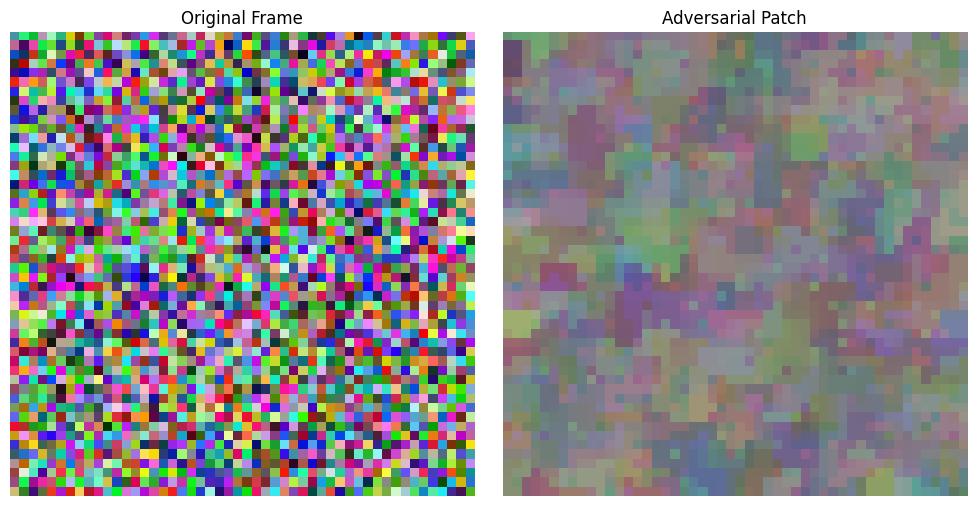

[*] First conf: 0.9715536236763
[*] Last conf: 0.9383440017700195
[*] First dist diff: 1.0167097270386285
[*] Last dist diff: 0.9761003601804091
Note conf: Lower conf misleads the system
Note dist: If dist diff division is high means that patch is effective (makes distance higher)


In [70]:
first_patch = tensor_to_numpy(train_df['Patch'].iloc[0])
last_patch = tensor_to_numpy(train_df['Patch'].iloc[-1])
print(f"[*] Number of patches: {train_df.shape[0]}")
if np.any(first_patch - last_patch != 0):
    print("Patch has been updated")
else:
    print("No change in patch")
subplot(first_patch, last_patch)

first_conf = train_df['Batch_pconf'].iloc[0]
last_conf = train_df['Batch_pconf'].iloc[-1]
first_dist = train_df['Batch_pdist'].iloc[0] / train_df['Batch_rdist'].iloc[0]
last_dist = train_df['Batch_pdist'].iloc[-1] / train_df['Batch_rdist'].iloc[-1]
print(f"[*] First conf: {first_conf}")
print(f"[*] Last conf: {last_conf}")
print(f"[*] First dist diff: {first_dist}")
print(f"[*] Last dist diff: {last_dist}")
print(f"Note conf: Lower conf misleads the system")
print(f"Note dist: If dist diff division is high means that patch is effective (makes distance higher)")